In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root

/home/IPP-HGW/patricks/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
s0 = 3
h0 = 1
w = 1
R1 = 1
R2 = 5

s = np.linspace(R1, R2, 100)
ds = (np.max(s)-np.min(s))/(len(s)-1)
h = h0*np.exp(-(s-s0)**2/w)
dh_ds = -h0*((2*(s-s0))/w)*np.exp(-(s-s0)**2/w)
sigma_1 = 1/((s+1j*h)*(1+1j*dh_ds))
sigma_2 = (s+1j*h)/(1+1j*dh_ds)
phi = np.zeros(len(s))


In [3]:
print(ds, s[1]-s[0])

0.04040404040404041 0.04040404040404044


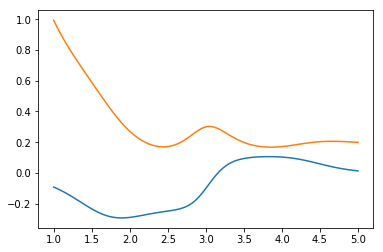

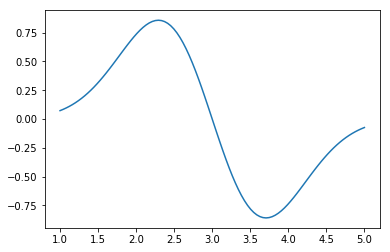

In [4]:
plt.plot(s, np.imag(sigma_1))
plt.plot(s, np.real(sigma_1))
plt.show()
plt.plot(s, dh_ds)
plt.show()

In [5]:
#Poisson Solver
@njit
def M(s, ds, sigma_1, sigma_2):
    col = np.zeros(3*len(s)-2)
    row = np.zeros(3*len(s)-2)
    data = np.zeros(3*len(s)-2)
    data[0] = 1
    col[1] = 1
    row[1] = 1
    data[1] = 1
    for i in prange(2, len(s)):
        row[3*i-4:3*i-1] = i
        col[3*i-4] = i-2
        col[3*i-3] = i-1
        col[3*i-2] = i
        data[3*i-4] = (s[i]-ds/2)/(ds**2*s[i])
        data[3*i-3] = -2/ds**2
        data[3*i-2] = (s[i]+ds/2)/(ds**2*s[i])
    return data, col, row

In [6]:
data, col, row = M(s, ds, sigma_1, sigma_2)
A = csc_matrix((data, (row, col)), shape=(len(s), len(s)))
#del data, col, row 
lu = sla.splu(A)

In [7]:
def shooting(phi0, phi1, s):
    def fun(phi1):
        f = np.zeros(len(s))
        f[0] = phi0
        f[1] = phi1
        phi = lu.solve(f)
        return phi[-1]
    Root = root(fun, phi1)
    return(Root.x[0])

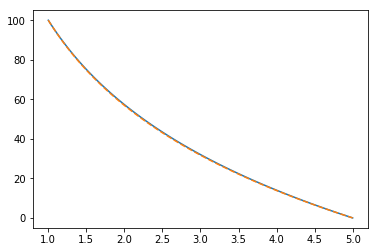

0.0


In [8]:
c1 = (-100/np.log(R2))*(1/(1+np.log(R1)/np.log(R2)))
c2 = -np.log(R2)*c1
phi_ana = c1*np.log(s) + c2

f = np.zeros(len(s))
f[0] = 100
f[1] = shooting(100, 100, s)
phi = lu.solve(f)

plt.plot(s, phi)
plt.plot(s, phi_ana, linestyle="dashed")
plt.show()
print(phi[-1]-phi_ana[-1])